# Question 2 (50 points)
In this question, you will simulate a peptide design experiment, trying to find peptides with high binding affinity to MHC class I using a bayesian optimization approach. Notice the goal here is not trying to find a peptide sequence that maximize the binding affinity to MHC, Since a sizable proportion of the sequence data we are using contains maximum binding affinity out of the data (9.0). Using the same feature encoding as question 1, we will examine several techniques to maximize the percentage of sequence with affinity of 9.0 for stringent querying.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.ensemble import RandomForestRegressor 

from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI

import seqlogo

import copy

### Set randome seed
seed = 5
random.seed(seed)
np.random.seed(seed)

# Reading and Processing the Data¶

In [2]:
data = np.loadtxt('hw3_data.csv', dtype = str, delimiter = ',')[1:]
### TO DO
peptide = data[:,2]
encode_order = 'ACDEFGHIKLMNPQRSTVWY'
def create_ohe_dictionary(encode_order):
    ohe_dict = {}
    encoding = 0
    for i in range(len(encode_order)):
        ohe_dict[encode_order[i]] = encoding
        encoding += 1
    return ohe_dict

ohe_dict = create_ohe_dictionary(encode_order)

def ohe_row(peptide_string, ohe_dict):
    idx = 0
    row = np.zeros(shape=9*len(ohe_dict))
    for aa in peptide_string:
        row[idx + ohe_dict[aa]] = 1
        idx += len(ohe_dict)
    return row

def one_hot_encoding(peptide, ohe_dict):
    ohe_encoding_peptide = np.zeros(shape=(len(peptide), 9 * len(ohe_dict)))
    for i in range(len(peptide)):
        ohe_encoding_peptide[i] = ohe_row(peptide[i], ohe_dict)
    return ohe_encoding_peptide

X = one_hot_encoding(peptide, ohe_dict)
y = data[:,3].astype('float64')

# 2.1: Random Sampling (5 pts. total) 

Create a random query strategy for randomly selecting a sample to query from the data. If the data selected is a new sequence with binding affnity of 9.0, append it to a list. After each query selection, measure the percentage of sequence with binding affnity 9.0 found by the strategy. Do this for 200 sampling steps. This will serve as the baseline to compare with optimizator performance in section 2.2 and 2.3.

In [3]:
X_cp = copy.deepcopy(X)
y_cp = copy.deepcopy(y)
optimal_idx_rand = []
history_rand = []
cnt = 0
### TO DO
n_query = 200
for i in range(n_query):
    idx = np.random.randint(0, len(y_cp))
    if y_cp[idx] == 9.0:
        cnt += 1
        optimal_idx_rand.append(X_cp[idx])    
    history_rand.append(cnt / (i+1))
    X_cp, y_cp = np.delete(X_cp, idx, axis=0), np.delete(y_cp, idx)

# 2.2: Baysian Optimization with Gaussian Process (15 pts. total)

Create a Baysian optimizer with Gaussian process as regressor and Max Expected improvement as the queuing strategy. If the data selected is a new sequence with binding affinity of 9.0, append it to a list. After each query selection, measure the percentage of sequence with binding affinity 9.0 found by the strategy. Do this for 200 sampling steps. 

$\textbf{Hint}$: Check the <a href="https://modal-python.readthedocs.io/en/latest/content/examples/bayesian_optimization.html#Optimizing-using-expected-improvement"> modAL documentation</a> for how to set up a Baysian optimizer.

In [4]:
X_cp = copy.deepcopy(X)
y_cp = copy.deepcopy(y)

optimal_idx_gp = []
history_gp = []
arr = np.arange(len(X_cp))
np.random.shuffle(arr)
### TO DO
# initializing the optimizer
optimizer = BayesianOptimizer(
    estimator=GaussianProcessRegressor(),
    X_training=X_cp[arr[:10]],
    y_training=y_cp[arr[:10]],
    query_strategy=max_EI
)
# Bayesian optimization
cnt = 0

for i in range(n_query):
    query_idx, query_inst = optimizer.query(X_cp)
    optimizer.teach(X_cp[query_idx].reshape(1, -1), y_cp[np.array(query_idx)].reshape(1))
    if y_cp[query_idx] == 9.0:
        cnt += 1
        optimal_idx_gp.append(X_cp[query_idx])    
    history_gp.append(cnt / (i+1))
    X_cp, y_cp = np.delete(X_cp, query_idx, axis=0), np.delete(y_cp, query_idx)

# 2.3: Bayesian Optimizer with Random Forest (10 pts. total)

Although Baysian optimization often uses the Gaussian process, Baysian optimizer in ModAL can take any other regressor that has a predict function with a return_std input parameter. If return_std is set to True, the function returns the predicted values and standard deviation in the prediction. Create a Baysian optimizer with random forest regressor and Max Expected improvement as the queuing strategy. If the data selected is a new sequence with binding affinity of 9.0, append it to a list. After each query selection, measure the percentage of sequences with binding affinity 9.0 found by the strategy. Do this for 200 sampling steps. 

$\textbf{Hint}$: You might find the following class wrapper for random forest helpful.

In [5]:
class rfwapper(RandomForestRegressor):
    def predict(self, X, return_std = False):
        if return_std:
            ys = np.array([e.predict(X) for e in self.estimators_])
            return np.mean(ys, axis = 0).ravel(), (np.std(ys, axis = 0).ravel() + 1e-6)
        return super().predict(X).ravel()

In [6]:
X_cp = copy.deepcopy(X)
y_cp = copy.deepcopy(y)

optimal_idx_rf = []
history_rf = []
arr = np.arange(len(X_cp))
np.random.shuffle(arr)

### TO DO
# initializing the optimizer
optimizer = BayesianOptimizer(
    estimator=rfwapper(),
    X_training=X_cp[arr[:10]],
    y_training=y_cp[arr[:10]],
    query_strategy=max_EI
)
# Bayesian optimization
cnt = 0
n_query = 200
for i in range(n_query):
    query_idx, query_inst = optimizer.query(X_cp)
    optimizer.teach(X_cp[query_idx].reshape(1, -1), y_cp[np.array(query_idx)].reshape(1))
    if y_cp[query_idx] == 9.0:
        cnt += 1
        optimal_idx_rf.append(X_cp[query_idx])
    history_rf.append(cnt / (i+1))
    X_cp, y_cp = np.delete(X_cp, query_idx, axis=0), np.delete(y_cp, query_idx)

# 2.4: Plot Percentage of sequence with maximum binding affinity with respect to number of sequence queried (10 pts. total)

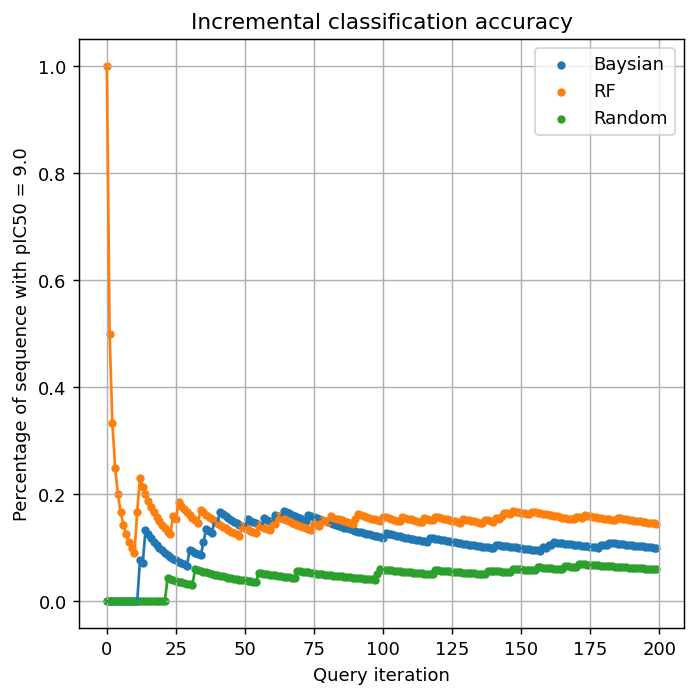

In [7]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(6, 6), dpi=130)

ax.plot(history_gp)
ax.scatter(range(len(history_gp)), history_gp, s=13, label = 'Baysian')


ax.plot(history_rf)
ax.scatter(range(len(history_rf)), history_rf, s=13, label = 'RF')


ax.plot(history_rand)
ax.scatter(range(len(history_rand)), history_rand, s=13, label = 'Random')

ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Percentage of sequence with pIC50 = 9.0')
ax.legend()
plt.show()

# 2.5: Create sequence logo based on sequences found with each querying strategies (5 pts. total)

A sequence logo is a graphical representation of the sequence conservation of amino acids in protein sequences), as amino acids that are important for functions are likely to be conserved. Hence, a sequence logo is a way to visualize such an importance. Convert the each sets of sequences obtained by one of your optimization strategies to a sequence logo. Below is an example using all of the sequence of affinity 9.0.


$\textbf{Important}$: We are using <a href="https://pypi.org/project/seqlogo/"> seqlogo</a> to create sequence logo from our set of sequences. You can install seqlogo by entering the command 

conda install -c bioconda seqlogo 

in your conda terminal

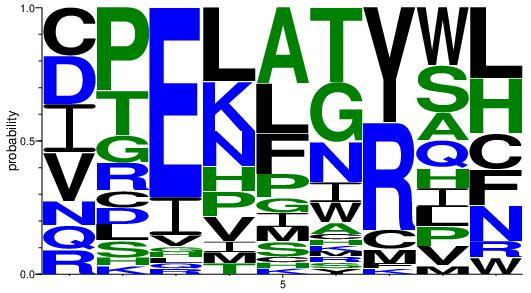

In [10]:
X_rf = optimal_idx_rf
ppm = np.sum(X_rf, axis = 0).reshape(20,9)
ppm /= np.sum(ppm, axis = 0)
ppm = seqlogo.Ppm(ppm, alphabet_type="AA")
seqlogo.seqlogo(ppm, ic_scale = False, format = 'jpeg', size = 'medium')